<a href="https://colab.research.google.com/github/adampotton/Group-3-gotta-catch-em-all-/blob/main/Final_model_both.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from PIL import Image
import random
import os
import csv
import shutil
from sklearn.metrics import f1_score
from google.colab import drive
from sklearn.model_selection import train_test_split
import os
from torchvision.transforms import v2
from torch.optim.lr_scheduler import ReduceLROnPlateau
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
drive.mount('/content/drive')
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# DATA LOADING

images1 = np.load('/content/drive/My Drive/PokemonTrainingData/images1.npy') # normal, unchanged images
labels1 = np.load('/content/drive/My Drive/PokemonTrainingData/labels1.npy')
labels1 = labels1[labels1<10]
images1 = images1[0:len(labels1)]

images2 = np.load('/content/drive/My Drive/PokemonTrainingData/images2.npy') # just normal images made binary
labels2 = np.load('/content/drive/My Drive/PokemonTrainingData/labels2.npy')
labels2 = labels2[labels2<10]
images2 = images2[0:len(labels2)]

images3 = np.load('/content/drive/My Drive/PokemonTrainingData/images3.npy') # images made into silouttes
labels3 = np.load('/content/drive/My Drive/PokemonTrainingData/labels3.npy')
labels3 = labels3[labels3<10]
images3 = images3[0:len(labels3)]

images4 = np.load('/content/drive/My Drive/PokemonTrainingData/images4.npy') # images made into filled silouttes
labels4 = np.load('/content/drive/My Drive/PokemonTrainingData/labels4.npy')
labels4 = labels4[labels4<10]
images4 = images4[0:len(labels4)]

imagesa1 = images1
imagesa2 = np.repeat(images2[:,:,:,np.newaxis],3, axis=3)
imagesa3 = np.repeat(images3[:,:,:,np.newaxis],3, axis=3)
imagesa4 = np.repeat(images4[:,:,:,np.newaxis],3, axis=3)
print(imagesa2.shape)
print(imagesa1.shape)

(1297, 224, 224, 3)
(1297, 224, 224, 3)


In [7]:
n = 10
pokemon_classes = ['Nidoqueen', 'Zapdos', 'Koffing', 'Scyther', 'Magnemite', 'Ivysaur', 'Exeggcute', 'Dragonite', 'Nidoran-f', 'Tangela', 'Rhyhorn', 'Blastoise', 'Cubone', 'Porygon', 'Ditto', 'Victreebell', 'Vulpix', 'Mewtwo', 'Venonat', 'Lickitung']
pokemon_classes = pokemon_classes[0:10]

In [8]:
# LOAD THE GOOD SILHOUTTES

folder_path = '/content/drive/My Drive/PokemonTrainingData/TEST POKEMON'
images_list = []

for class_name in pokemon_classes:
    image_path = os.path.join(folder_path, class_name + '.jpg')
    if os.path.exists(image_path):
        image = Image.open(image_path)
        image = image.resize((224, 224))
        image_array = np.array(image)
        images_list.append(image_array)

images_array = np.stack(images_list, axis=0)


In [9]:
def test():
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            if num_input_channels == 1:
                logits = model(images.unsqueeze(1))
            else:
                logits = model(images.permute(0, 3, 1, 2))

            # Compute total correct so far
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
        print(f'test accuracy {100 * correct / total:.2f}%')
        scheduler.step(accuracy)




In [11]:


batch_size = 32
num_epochs = 25
num_input_channels = 3
for i in range(1, 5):


    print(num_input_channels)
    # Choose the images and labels for this iteration
    img = globals()[f'imagesa{i}']
    lab = globals()[f'labels{i}']

    train_images, test_images, train_labels, test_labels = train_test_split(
       img, lab, test_size=0.2, random_state=2, stratify=lab
    )

     #split test into validation and test
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=2, stratify=test_labels
    )
    # Convert NumPy arrays to PyTorch tensors
    train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
    test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
    test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
    val_images_tensor = torch.tensor(val_images, dtype=torch.float32)
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
    val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    # Define the number of classes
    num_classes = n

    # MOBILENETV2 MODEL
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torchvision.models.mobilenet_v2(weights=None)

    # Modify the fully connected layer to match the number of classes dataset
    num_classes = len(pokemon_classes)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)

    # Move the model to the appropriate device
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    train_loss_list1 = []
    val_accuracy_list = []
    y_true1 = []
    y_pred1 = []
    val_f1_list1 = []
    # Train the model
    accuracy_list = []
    early_stopping_patience = 4
    best_val_loss = np.inf
    no_improvement_counter = 0
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)


            logits = model(images.permute(0, 3, 1, 2))

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss_list1.append(loss.item())
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)


                logits = model(images.permute(0, 3, 1, 2))

                predicted = torch.argmax(logits, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                accuracy = 100 * correct / total

                y_true1.extend(labels.cpu().numpy())
                y_pred1.extend(predicted.cpu().numpy())
                accuracy = 100 * correct / total
                f1 = f1_score(y_true1, y_pred1, average='macro')
            val_f1_list1.append(f1)
            val_accuracy_list.append(accuracy)
            print(f'Test accuracy after {epoch+1} epochs: {accuracy:.2f}%')
            scheduler.step(accuracy)
            val_loss = loss.item()  # You can replace this with your validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

            if no_improvement_counter >= early_stopping_patience:
                print("Early stopping triggered! No improvement in validation loss.")
                break


    # Save the accuracy list for this loop
    globals()[f'accuracy_list_{i}'] = val_accuracy_list
    globals()[f'val_f1_list_{i}'] = val_f1_list1
    globals()[f'train_loss_list_{i}'] = train_loss_list1

    test()

3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Test accuracy after 1 epochs: 10.00%
Test accuracy after 2 epochs: 13.85%
Test accuracy after 3 epochs: 56.92%
Test accuracy after 4 epochs: 65.38%
Test accuracy after 5 epochs: 72.31%
Test accuracy after 6 epochs: 78.46%
Test accuracy after 7 epochs: 77.69%
Test accuracy after 8 epochs: 73.85%
Test accuracy after 9 epochs: 76.15%
Test accuracy after 10 epochs: 81.54%
Test accuracy after 11 epochs: 82.31%
Test accuracy after 12 epochs: 83.08%
Test accuracy after 13 epochs: 84.62%
Test accuracy after 14 epochs: 84.62%
Test accuracy after 15 epochs: 83.08%
Test accuracy after 16 epochs: 83.85%
Test accuracy after 17 epochs: 83.85%
Test accuracy after 18 epochs: 83.08%
Test accuracy after 19 epochs: 80.77%
Test accuracy after 20 epochs: 83.08%
Test accuracy after 21 epochs: 83.85%
Test accuracy after 22 epochs: 83.08%
Test accuracy after 23 epochs: 84.62%
Test accuracy after 24 epochs: 84.62%
Early stopping triggered! No improvement in validation loss.
test accuracy 87.69%
3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Test accuracy after 1 epochs: 11.54%
Test accuracy after 2 epochs: 10.00%
Test accuracy after 3 epochs: 25.38%
Test accuracy after 4 epochs: 30.00%
Test accuracy after 5 epochs: 40.77%
Test accuracy after 6 epochs: 26.92%
Test accuracy after 7 epochs: 39.23%
Test accuracy after 8 epochs: 43.85%
Test accuracy after 9 epochs: 36.15%
Test accuracy after 10 epochs: 38.46%
Test accuracy after 11 epochs: 50.00%
Test accuracy after 12 epochs: 45.38%
Test accuracy after 13 epochs: 46.15%
Test accuracy after 14 epochs: 44.62%
Test accuracy after 15 epochs: 43.85%
Test accuracy after 16 epochs: 49.23%
Test accuracy after 17 epochs: 46.15%
Test accuracy after 18 epochs: 45.38%
Test accuracy after 19 epochs: 46.15%
Test accuracy after 20 epochs: 46.15%
Test accuracy after 21 epochs: 46.15%
Test accuracy after 22 epochs: 48.46%
Test accuracy after 23 epochs: 48.46%
Early stopping triggered! No improvement in validation loss.
test accuracy 49.23%
3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Test accuracy after 1 epochs: 15.62%
Test accuracy after 2 epochs: 15.62%
Test accuracy after 3 epochs: 15.62%
Test accuracy after 4 epochs: 15.62%
Test accuracy after 5 epochs: 9.38%
Test accuracy after 6 epochs: 15.62%
Test accuracy after 7 epochs: 15.62%
Test accuracy after 8 epochs: 15.62%
Test accuracy after 9 epochs: 15.62%
Test accuracy after 10 epochs: 21.88%
Test accuracy after 11 epochs: 34.38%
Test accuracy after 12 epochs: 25.00%
Test accuracy after 13 epochs: 25.00%
Test accuracy after 14 epochs: 28.12%
Test accuracy after 15 epochs: 28.12%
Test accuracy after 16 epochs: 31.25%
Test accuracy after 17 epochs: 31.25%
Test accuracy after 18 epochs: 31.25%
Early stopping triggered! No improvement in validation loss.
test accuracy 37.50%
3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Test accuracy after 1 epochs: 9.38%
Test accuracy after 2 epochs: 9.38%
Test accuracy after 3 epochs: 9.38%
Test accuracy after 4 epochs: 9.38%
Test accuracy after 5 epochs: 9.38%
Test accuracy after 6 epochs: 9.38%
Test accuracy after 7 epochs: 9.38%
Test accuracy after 8 epochs: 9.38%
Test accuracy after 9 epochs: 9.38%
Test accuracy after 10 epochs: 15.62%
Test accuracy after 11 epochs: 21.88%
Test accuracy after 12 epochs: 34.38%
Test accuracy after 13 epochs: 34.38%
Test accuracy after 14 epochs: 40.62%
Test accuracy after 15 epochs: 40.62%
Test accuracy after 16 epochs: 37.50%
Test accuracy after 17 epochs: 37.50%
Test accuracy after 18 epochs: 37.50%
Test accuracy after 19 epochs: 34.38%
Test accuracy after 20 epochs: 37.50%
Test accuracy after 21 epochs: 34.38%
Test accuracy after 22 epochs: 34.38%
Test accuracy after 23 epochs: 34.38%
Early stopping triggered! No improvement in validation loss.
test accuracy 25.00%


In [13]:
batch_size = 32
num_epochs = 25

for i in range(1, 5):

    # Determine the number of input channels
    num_input_channels = 3 if i == 1 else 1

    # Choose the images and labels for this iteration
    img = globals()[f'images{i}']
    lab = globals()[f'labels{i}']

    train_images, test_images, train_labels, test_labels = train_test_split(
       img, lab, test_size=0.2, random_state=2, stratify=lab
    )

     #split test into validation and test
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_images, test_labels, test_size=0.5, random_state=2, stratify=test_labels
    )
    # Convert NumPy arrays to PyTorch tensors
    train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
    test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
    test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
    val_images_tensor = torch.tensor(val_images, dtype=torch.float32)
    val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)

    # Create PyTorch datasets and dataloaders
    train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
    test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
    val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


    # Define the number of classes
    num_classes = n

    # Define the model architecture
    model = nn.Sequential(
        nn.Conv2d(num_input_channels, 16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32 * 56 * 56, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )

    # Move model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)
    criterion = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    train_loss_list1 = []
    val_accuracy_list = []
    y_true1 = []
    y_pred1 = []
    val_f1_list1 = []
    # Train the model
    accuracy_list = []
    early_stopping_patience = 5
    best_val_loss = np.inf
    no_improvement_counter = 0
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            if num_input_channels == 1:
                #print(images.unsqueeze(1).shape)
                logits = model(images.unsqueeze(1))
                #logits = logits
                #print(logits.shape)
            else:
                logits = model(images.permute(0, 3, 1, 2))

            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss_list1.append(loss.item())
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                if num_input_channels == 1:
                    logits = model(images.unsqueeze(1))
                else:
                    logits = model(images.permute(0, 3, 1, 2))

                predicted = torch.argmax(logits, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                accuracy = 100 * correct / total

                y_true1.extend(labels.cpu().numpy())
                y_pred1.extend(predicted.cpu().numpy())
                accuracy = 100 * correct / total
                f1 = f1_score(y_true1, y_pred1, average='macro')
            val_f1_list1.append(f1)
            val_accuracy_list.append(accuracy)
            print(f'Test accuracy after {epoch+1} epochs: {accuracy:.2f}%')
            scheduler.step(accuracy)
            val_loss = loss.item()  # You can replace this with your validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

            if no_improvement_counter >= early_stopping_patience:
                print("Early stopping triggered! No improvement in validation loss.")
                break


    # Save the accuracy list for this loop
    globals()[f'accuracy_list_{i+4}'] = val_accuracy_list
    globals()[f'val_f1_list_{i+4}'] = val_f1_list1
    globals()[f'train_loss_list_{i+4}'] = train_loss_list1

    test()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Test accuracy after 1 epochs: 56.92%
Test accuracy after 2 epochs: 71.54%
Test accuracy after 3 epochs: 73.85%
Test accuracy after 4 epochs: 76.15%
Test accuracy after 5 epochs: 80.77%
Test accuracy after 6 epochs: 80.77%
Test accuracy after 7 epochs: 82.31%
Test accuracy after 8 epochs: 81.54%
Test accuracy after 9 epochs: 80.00%
Test accuracy after 10 epochs: 83.08%
Test accuracy after 11 epochs: 81.54%
Test accuracy after 12 epochs: 82.31%
Test accuracy after 13 epochs: 83.08%
Early stopping triggered! No improvement in validation loss.
test accuracy 82.31%


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Test accuracy after 1 epochs: 13.08%
Test accuracy after 2 epochs: 29.23%
Test accuracy after 3 epochs: 33.85%
Test accuracy after 4 epochs: 38.46%
Test accuracy after 5 epochs: 47.69%
Test accuracy after 6 epochs: 48.46%
Test accuracy after 7 epochs: 47.69%
Test accuracy after 8 epochs: 50.00%
Test accuracy after 9 epochs: 46.15%
Test accuracy after 10 epochs: 47.69%
Test accuracy after 11 epochs: 47.69%
Test accuracy after 12 epochs: 49.23%
Test accuracy after 13 epochs: 49.23%
Test accuracy after 14 epochs: 48.46%
Test accuracy after 15 epochs: 48.46%
Test accuracy after 16 epochs: 48.46%
Test accuracy after 17 epochs: 49.23%
Test accuracy after 18 epochs: 48.46%
Test accuracy after 19 epochs: 49.23%
Test accuracy after 20 epochs: 50.77%
Test accuracy after 21 epochs: 49.23%
Test accuracy after 22 epochs: 50.00%
Test accuracy after 23 epochs: 50.00%
Early stopping triggered! No improvement in validation loss.
test accuracy 56.92%


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Test accuracy after 1 epochs: 9.38%
Test accuracy after 2 epochs: 6.25%
Test accuracy after 3 epochs: 12.50%
Test accuracy after 4 epochs: 37.50%
Test accuracy after 5 epochs: 50.00%
Test accuracy after 6 epochs: 46.88%
Test accuracy after 7 epochs: 40.62%
Test accuracy after 8 epochs: 40.62%
Test accuracy after 9 epochs: 40.62%
Test accuracy after 10 epochs: 40.62%
Test accuracy after 11 epochs: 40.62%
Test accuracy after 12 epochs: 40.62%
Test accuracy after 13 epochs: 40.62%
Test accuracy after 14 epochs: 40.62%
Test accuracy after 15 epochs: 40.62%
Test accuracy after 16 epochs: 40.62%
Test accuracy after 17 epochs: 40.62%
Early stopping triggered! No improvement in validation loss.
test accuracy 46.88%


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Test accuracy after 1 epochs: 9.38%
Test accuracy after 2 epochs: 18.75%
Test accuracy after 3 epochs: 34.38%
Test accuracy after 4 epochs: 46.88%
Test accuracy after 5 epochs: 43.75%
Test accuracy after 6 epochs: 46.88%
Test accuracy after 7 epochs: 50.00%
Test accuracy after 8 epochs: 50.00%
Test accuracy after 9 epochs: 46.88%
Test accuracy after 10 epochs: 46.88%
Test accuracy after 11 epochs: 46.88%
Test accuracy after 12 epochs: 46.88%
Test accuracy after 13 epochs: 46.88%
Test accuracy after 14 epochs: 46.88%
Test accuracy after 15 epochs: 46.88%
Test accuracy after 16 epochs: 46.88%
Early stopping triggered! No improvement in validation loss.
test accuracy 50.00%


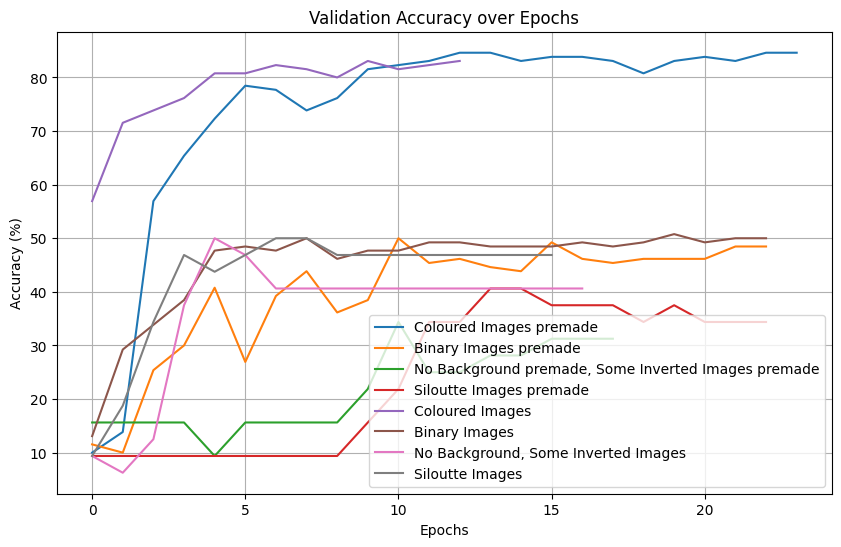

In [17]:
plt.figure(figsize=(10, 6))
legend = ['Coloured Images premade','Binary Images premade','No Background premade, Some Inverted Images premade','Siloutte Images premade','Coloured Images','Binary Images','No Background, Some Inverted Images','Siloutte Images']
for i in range(1, 9):
    accuracy_list = globals()[f'accuracy_list_{i}']
    epochs = range(0, len(accuracy_list))
    plt.plot(epochs, accuracy_list, label=legend[i-1])

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy over Epochs')
plt.legend()  # Add legend
plt.grid(True)  # Add grid
plt.show()


24
24
23
23
18
18
23
23
13
13
23
23
17
17
16
16


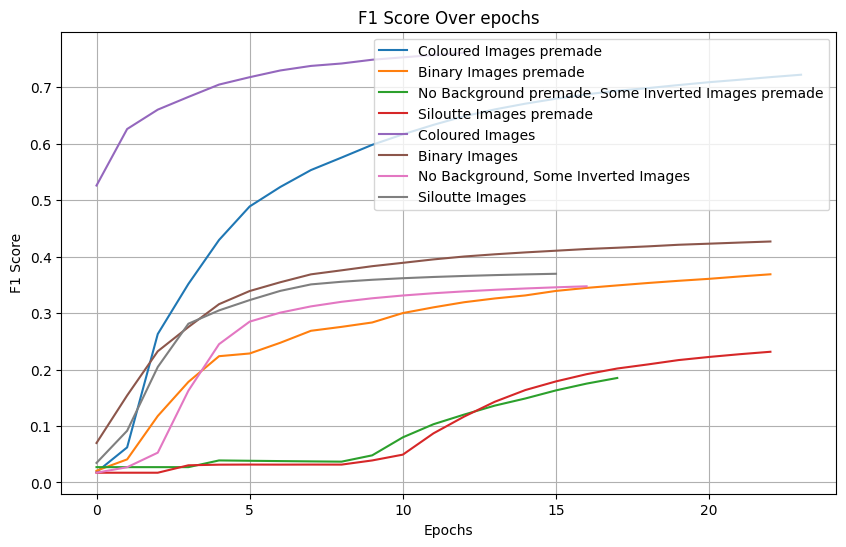

In [15]:
plt.figure(figsize=(10, 6))
legend = ['Coloured Images premade','Binary Images premade','No Background premade, Some Inverted Images premade','Siloutte Images premade','Coloured Images','Binary Images','No Background, Some Inverted Images','Siloutte Images']
for i in range(1, 9):
    accuracy_list = globals()[f'val_f1_list_{i}']
    epochs = range(0, len(accuracy_list))
    print(len(epochs))
    print(len(accuracy_list))
    plt.plot(epochs, accuracy_list, label=legend[i-1])

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Over epochs')
plt.legend()  # Add legend
plt.grid(True)  # Add grid
plt.show()


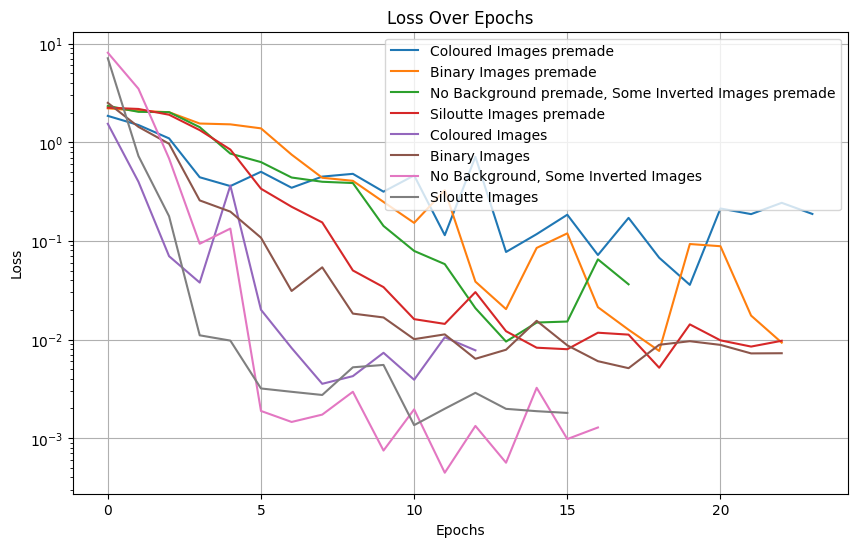

In [16]:
plt.figure(figsize=(10, 6))
legend = ['Coloured Images premade','Binary Images premade','No Background premade, Some Inverted Images premade','Siloutte Images premade','Coloured Images','Binary Images','No Background, Some Inverted Images','Siloutte Images']
for i in range(1, 9):
    accuracy_list = globals()[f'train_loss_list_{i}']
    epochs = range(0, len(accuracy_list))
    plt.plot(epochs, accuracy_list, label=legend[i-1])

# Add labels and title
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()  # Add legend
plt.grid(True)  # Add grid
plt.show()

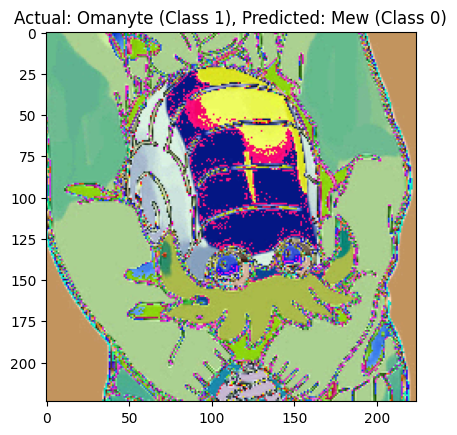

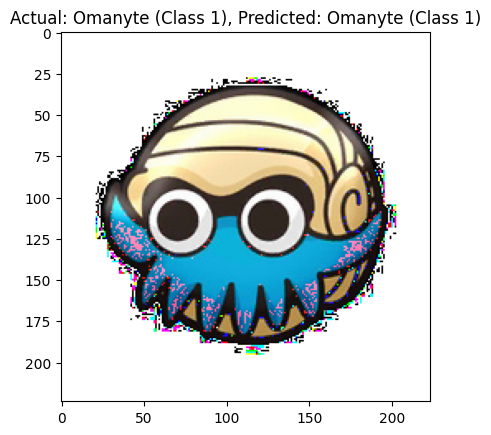

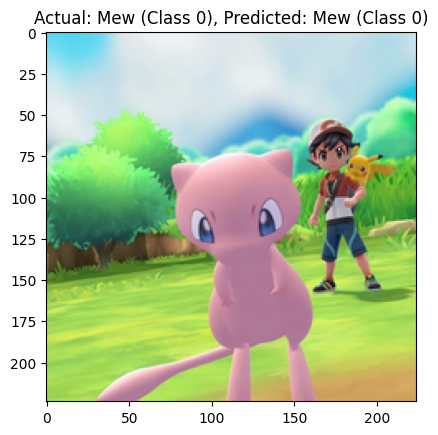

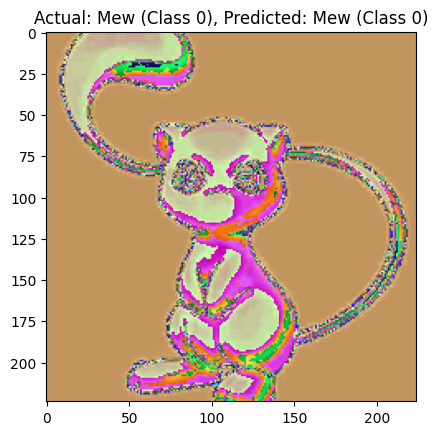

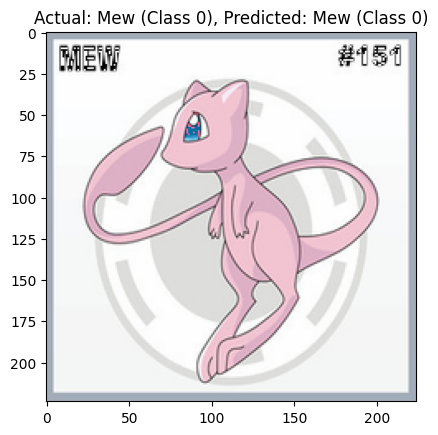

In [ ]:
# SHOWING MODEL PREDICITONS

def display_random_image_prediction(num_runs):
  for i in range(1,num_runs):
    index_to_display = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[index_to_display]
    image = image.unsqueeze(0).to(device)
    logits = model(image.permute(0, 3, 1, 2))
    predicted_label = torch.argmax(logits).item()
    np_image = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
    np_image = 255 - np_image
    plt.imshow(np_image)
    plt.title(f"Actual: {pokemon_classes[label]} (Class {label}), Predicted: {pokemon_classes[predicted_label]} (Class {predicted_label})")
    plt.show()

display_random_image_prediction(3)
